In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from tqdm import tqdm

In [ ]:
hbar = 1.0
m = 1.0

compute = 1  # set to 0 if want to read stored results instead of calculating them

In [ ]:
# Paths to store the calculated data

exact_x_path = 'Exact_Quantum_in_Position_Basis'
exact_HO_path = 'Exact_Quantum_in_Harmonic_Eigenstates'
classical_path = 'Classical'
polymer_path = 'Ring_Polymer'
cube_path = 'Cube'

# Potential Functions

In [ ]:
def harmonic(x):
    return x**2/2

def slightly_anharmonic(x):
    return x**2/2 + x**3/10 + x**4/100

def anharmonic(x):
    return x**4 / 4

# Exact Quantum Solution

Kubo-transformed correlation function:
$$
K_{AB}(t)=\frac{1}{Z}\sum_{|n\rangle}\sum_{|m\rangle} \mathrm{e}^{-\beta E_n}\mathrm{e}^{-\mathrm{i}(E_n-E_m)t/\hbar}A_{nm}B_{mn}\frac{\mathrm{e}^{\beta(E_n-E_m)-1}}{\beta(E_n-E_m)}
$$

## In position representation

Here we expand the eigenstates in the position representation.

Potential energy matrix is trivial.

The second derivative of a function can be estimated by its values on a grid:
$$ \frac{\mathrm{d}^2}{\mathrm{d}x^2}f(x)=\lim_{\delta x\to 0}\frac{f(x+\delta x)+f(x-\delta x)-2f(x)}{\delta x^2}\,, $$
so its matrix representation in finite grid form is
$$\begin{pmatrix}
    -2 & 1 & 0 & \cdots & 0 \\
    1 & -2 & 1 & \cdots & 0 \\
    0 & 1 & -2 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \cdots & -2
\end{pmatrix}\,.$$
The kinetic operator is then trivial.

In [ ]:
def exact_quantum_position(x_min, x_max, dx, beta, potential, t_end, t_N):
    # Spatial grid
    x = np.arange(x_min, x_max, dx)
    N = len(x)

    potential_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    V = potential_map[potential](x)

    # Kinetic energy operator
    T_diag = np.full(N, -2.0)
    T_off = np.ones(N - 1)
    T = np.diag(T_diag) + np.diag(T_off, k=1) + np.diag(T_off, k=-1)
    T *= -hbar**2 / (2 * m * dx**2)

    # Hamiltonian
    H = T + np.diag(V)

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x
    A = np.diag(x)
    A_mat = psi.T @ A @ psi

    # Compute Partition Function
    max_energy = 10                                     # Ignore state above this energy
    valid_indices = np.where(E <= max_energy)[0]
    E = E[valid_indices]
    psi = psi[:, valid_indices]
    A_mat = A_mat[np.ix_(valid_indices, valid_indices)]
    exp_beta_E = np.exp(-beta * E)

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z      # sum over j,k

    return times, C_t

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [167]:
x_min = -5.5
x_max = 5.5
dx = 0.01
N = int((x_max-x_min)/dx)
beta = 1

print(N)

V_max = harmonic(x_max)*beta
print(V_max)

1100
15.125


In [168]:
if compute == 1:
    exact_harmonic_x = exact_quantum_position(x_min,x_max,dx,beta,'harmonic',25,250)
    np.save(f'{exact_x_path}/harmonic.npy', exact_harmonic_x)

In [169]:
exact_harmonic_x = np.load(f'{exact_x_path}/harmonic.npy')

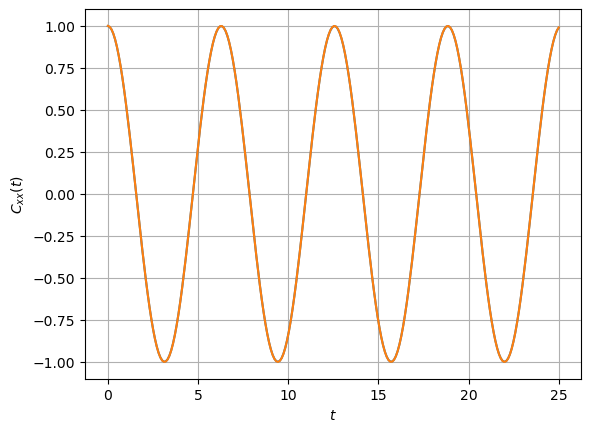

In [170]:
plt.plot(exact_harmonic_x[0], exact_harmonic_x[1])
plt.plot(exact_harmonic_x[0], np.cos(exact_harmonic_x[0]))
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [171]:
x_min = -7.2
x_max = 4
dx = 0.01
N = int((x_max-x_min)/dx)
beta = 1

print(N)

V_max_highT_lb = slightly_anharmonic(x_min)*beta
V_max_highT_hb = slightly_anharmonic(x_max)*beta
print(V_max_highT_lb,V_max_highT_hb)

1120
15.469055999999998 16.96


In [172]:
if compute == 1:
    exact_slightly_anharmonic_highT_x = exact_quantum_position(x_min,x_max,0.01,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_x_path}/slightly_anharmonic_highT.npy', exact_slightly_anharmonic_highT_x)

In [173]:
exact_slightly_anharmonic_highT_x = np.load(f'{exact_x_path}/slightly_anharmonic_highT.npy')

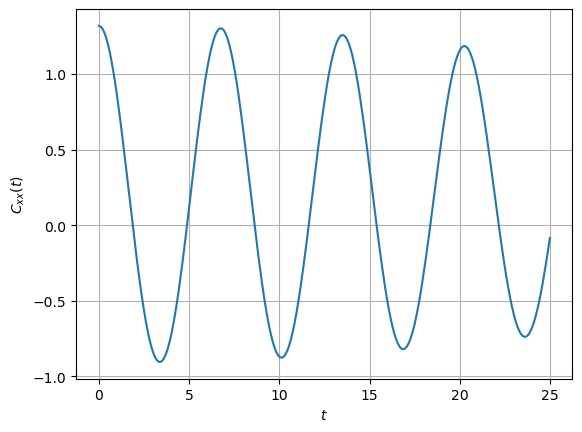

In [174]:
plt.plot(exact_slightly_anharmonic_highT_x[0], exact_slightly_anharmonic_highT_x[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [175]:
x_min = -4.8
x_max = 2.9
dx = 0.005
N = int((x_max-x_min)/dx)
beta = 8

print(N)

V_max_lowT_lb = slightly_anharmonic(x_min)*beta
V_max_lowT_hb = slightly_anharmonic(x_max)*beta
print(V_max_lowT_lb,V_max_lowT_hb)

1539
46.153728 58.809448


In [176]:
if compute == 1:
    exact_slightly_anharmonic_lowT_x = exact_quantum_position(x_min,x_max,dx,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_x_path}/slightly_anharmonic_lowT.npy', exact_slightly_anharmonic_lowT_x)

In [177]:
exact_slightly_anharmonic_lowT_x = np.load(f'{exact_x_path}/slightly_anharmonic_lowT.npy')

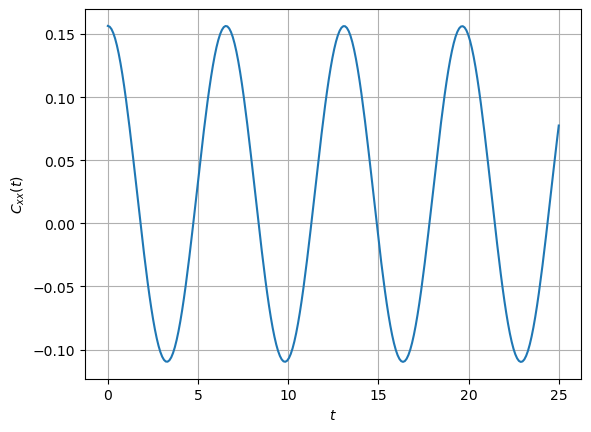

In [178]:
plt.plot(exact_slightly_anharmonic_lowT_x[0], exact_slightly_anharmonic_lowT_x[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [179]:
x_min = -3
x_max = 3
dx = 0.005
N = int((x_max-x_min)/dx)
beta = 1

print(N)

V_max_highT = anharmonic(x_max)*beta
print(V_max_highT)

1200
20.25


In [180]:
if compute == 1:
    exact_anharmonic_highT_x = exact_quantum_position(x_min,x_max,dx,beta,'anharmonic',25,250)
    np.save(f'{exact_x_path}/anharmonic_highT.npy', exact_anharmonic_highT_x)

In [181]:
exact_anharmonic_highT_x = np.load(f'{exact_x_path}/anharmonic_highT.npy')

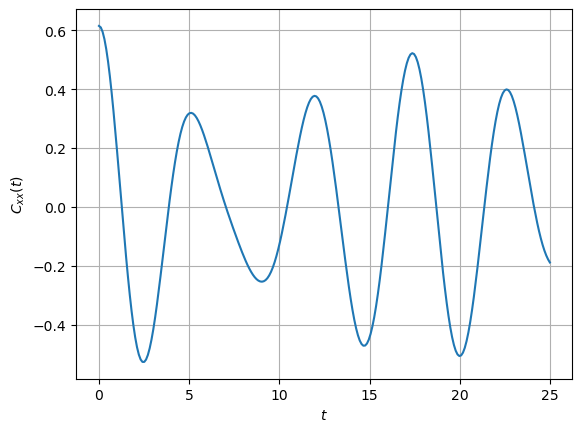

In [182]:
plt.plot(exact_anharmonic_highT_x[0], exact_anharmonic_highT_x[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [183]:
x_min = -3
x_max = 3
dx = 0.005
N = int((x_max-x_min)/dx)
beta = 8

print(N)

V_max_lowT = anharmonic(x_max)*beta
print(V_max_lowT)

1200
162.0


In [184]:
if compute == 1:
    exact_anharmonic_lowT_x = exact_quantum_position(x_min,x_max,dx,beta,'anharmonic',25,250)
    np.save(f'{exact_x_path}/anharmonic_lowT.npy', exact_anharmonic_lowT_x)

In [185]:
exact_anharmonic_lowT_x = np.load(f'{exact_x_path}/anharmonic_lowT.npy')

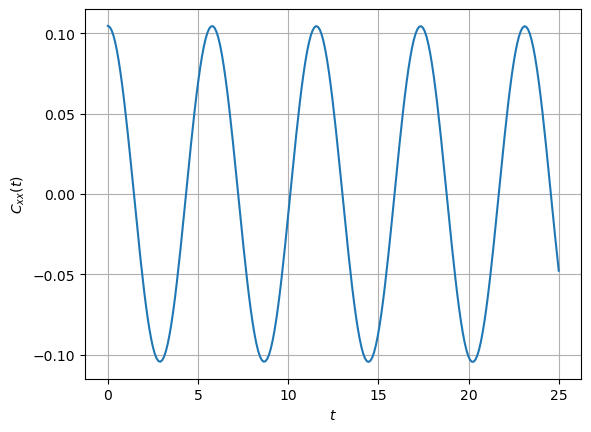

In [186]:
plt.plot(exact_anharmonic_lowT_x[0], exact_anharmonic_lowT_x[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()


## In Harmonic Eigenstates

We now expand the eigenstates in the eigenstates of a Harmonic oscillator. We can use the ladder operators, which acts on the harmonic states as follows.
\begin{align*}
    \hat{a} | n \rangle &= \sqrt{n} | n-1 \rangle\,,\\
    \hat{a}^\dagger | n \rangle &= \sqrt{n+1} | n+1 \rangle\,.
\end{align*}

The position and momentum operators can be expressed in terms of the ladder operators.
\begin{align*}
    x&=\sqrt{\frac{\hbar}{2m}}(\hat{a}^\dagger+\hat{a})\,,\\
    p&=\mathrm{i}\sqrt{\frac{m\hbar}{2}}(\hat{a}^\dagger - \hat{a})\,.
\end{align*}
The kinetic and potential operators are then trivial.

This is much more efficient than the position representation.

In [ ]:
def exact_quantum_HO(n_max, beta, potential, t_end, t_N):

    potential_coefficients = {
        'harmonic': [1/2,0,0],
        'slightly_anharmonic': [1/2,1/10,1/100],
        'anharmonic': [0,0,1/4]
    }

    dim = n_max + 4                 # We need up x^4 in the potential operator. a^4 will lower the n+4 state to n.

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    adag = a.T

    # Position operator
    x = np.sqrt(hbar/(2*m)) * (a + adag)

    x2 = x @ x
    x3 = x2 @ x
    x4 = x3 @ x

    x_powers = [x2,x3,x4]

    V = np.zeros((dim,dim))
    for i in range(0,3):
        V += potential_coefficients[potential][i] * x_powers[i]

    # Kinetic energy operator

    dv = np.sqrt(m * hbar / 2) * (adag - a)

    T = -(dv @ dv) / (2 * m)

    # Hamiltonian
    H = T + V

    H = H[:n_max,:n_max]

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x
    A = x[:n_max,:n_max]
    A_mat = psi.T @ A @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z

    return times, C_t

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [188]:
beta = 1
if compute == 1:
    exact_harmonic_HO = exact_quantum_HO(10,beta,'harmonic',25,250)
    np.save(f'{exact_HO_path}/harmonic.npy', exact_harmonic_HO)

In [189]:
exact_harmonic_HO = np.load(f'{exact_HO_path}/harmonic.npy')

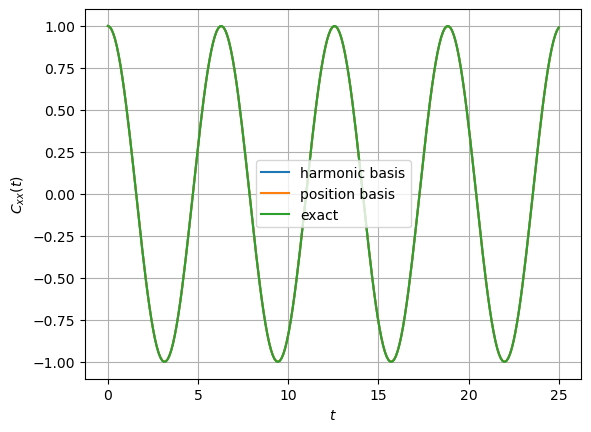

In [190]:
plt.plot(exact_harmonic_HO[0], exact_harmonic_HO[1], label='harmonic basis')
plt.plot(exact_harmonic_x[0], exact_harmonic_x[1], label='position basis')
plt.plot(exact_harmonic_HO[0], np.cos(exact_harmonic_HO[0]), label='exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [191]:
beta = 1
if compute == 1:
    exact_slightly_anharmonic_highT_HO = exact_quantum_HO(20,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_HO_path}/slightly_anharmonic_highT.npy', exact_slightly_anharmonic_highT_HO)

In [192]:
exact_slightly_anharmonic_highT_HO = np.load(f'{exact_HO_path}/slightly_anharmonic_highT.npy')

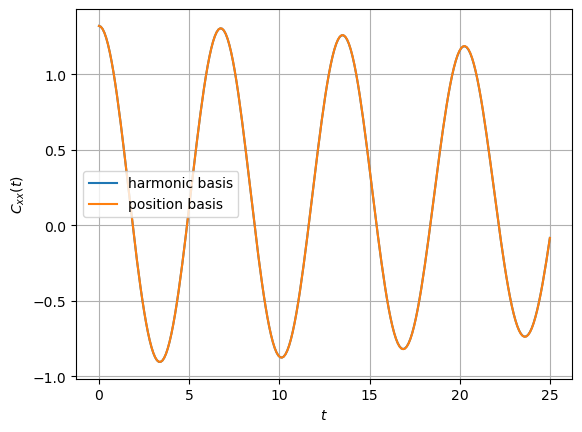

In [193]:
plt.plot(exact_slightly_anharmonic_highT_HO[0], exact_slightly_anharmonic_highT_HO[1], label='harmonic basis')
plt.plot(exact_slightly_anharmonic_highT_x[0], exact_slightly_anharmonic_highT_x[1], label='position basis')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [194]:
beta = 8
if compute == 1:
    exact_slightly_anharmonic_lowT_HO = exact_quantum_HO(10,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_HO_path}/slightly_anharmonic_lowT.npy', exact_slightly_anharmonic_lowT_HO)

In [195]:
exact_slightly_anharmonic_lowT_HO = np.load(f'{exact_HO_path}/slightly_anharmonic_lowT.npy')

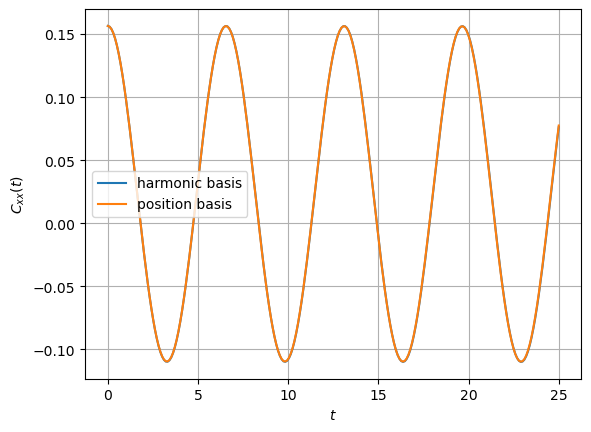

In [196]:
plt.plot(exact_slightly_anharmonic_lowT_HO[0], exact_slightly_anharmonic_lowT_HO[1], label='harmonic basis')
plt.plot(exact_slightly_anharmonic_lowT_x[0], exact_slightly_anharmonic_lowT_x[1], label='position basis')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [197]:
beta = 1
if compute == 1:
    exact_anharmonic_highT_HO = exact_quantum_HO(20,beta,'anharmonic',25,250)
    np.save(f'{exact_HO_path}/anharmonic_highT.npy', exact_anharmonic_highT_HO)

In [198]:
exact_anharmonic_highT_HO = np.load(f'{exact_HO_path}/anharmonic_highT.npy')

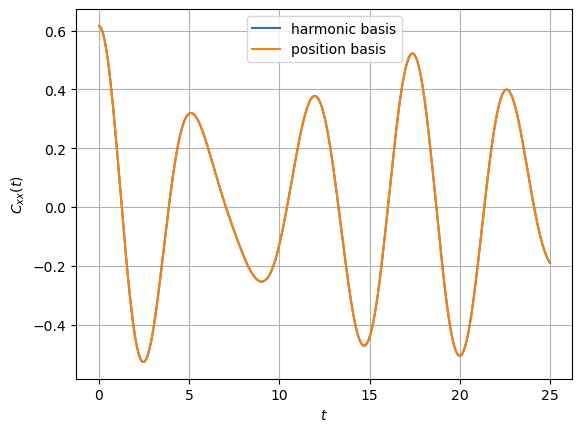

In [199]:
plt.plot(exact_anharmonic_highT_HO[0], exact_anharmonic_highT_HO[1], label='harmonic basis')
plt.plot(exact_anharmonic_highT_x[0], exact_anharmonic_highT_x[1], label='position basis')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [ ]:
beta = 8
if compute == 1:
    exact_anharmonic_lowT_HO = exact_quantum_HO(10,beta,'anharmonic',25,250)
    np.save(f'{exact_HO_path}/anharmonic_lowT.npy', exact_anharmonic_lowT_HO)

In [202]:
exact_anharmonic_lowT_HO = np.load(f'{exact_HO_path}/anharmonic_lowT.npy')

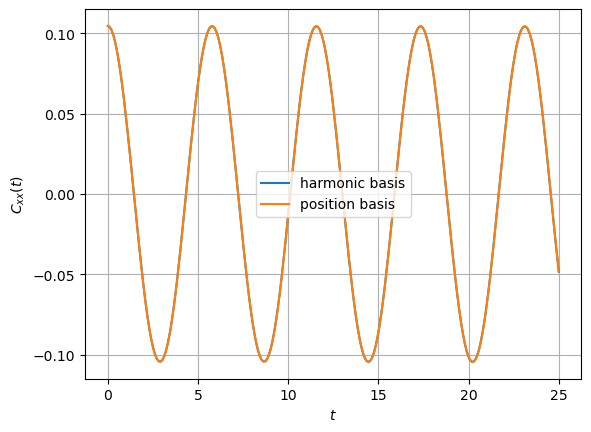

In [203]:
plt.plot(exact_anharmonic_lowT_HO[0], exact_anharmonic_lowT_HO[1], label='harmonic basis')
plt.plot(exact_anharmonic_lowT_x[0], exact_anharmonic_lowT_x[1], label='position basis')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


# Classical Solution

In [204]:
def F_harmonic(x):
    return -x

def F_slightly_anharmonic(x):
    return -x - 3*x**2/10 - x**3/25

def F_anharmonic(x):
    return -x**3

In [ ]:
# Using verlet algorithm to propagate the classical particle.

def verlet(x_init, v_init, potential, time, delta_t):
    t_values = np.arange(0, time, delta_t)
    N = len(t_values)

    force_map = {
        'harmonic': F_harmonic,
        'slightly_anharmonic': F_slightly_anharmonic,
        'anharmonic': F_anharmonic
    }
    force = force_map[potential]

    x_verlet = np.zeros(N)
    v_verlet = np.zeros(N)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        f = force(x_verlet[i])
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = force(x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [ ]:
def classical(x_low, x_up, x_step, v_low, v_up, v_step, potential, time, delta_t, beta):
    C_time = np.arange(0, time, delta_t)
    N = len(C_time)

    energy_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    energy = energy_map[potential]

    C_func = np.zeros(N)
    partition_function = 0.0

    # Uniform sampling
    x_vals = np.arange(x_low, x_up, x_step)
    v_vals = np.arange(v_low, v_up, v_step)

    for x_init in tqdm(x_vals, desc="Classical Sampling"):
        for v_init in v_vals:
            E = energy(x_init) + 0.5 * m * v_init**2
            weight = np.exp(-beta * E)                                               # Weight by Boltzmann factor
            x_traj, _ = verlet(x_init, v_init, potential, time, delta_t)

            C_func += x_traj * x_init * weight
            partition_function += weight

    C_func /= partition_function
    return C_time, C_func


$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [207]:
beta = 1
if compute == 1:
    classical_harmonic = classical(-5.5,5.5,0.1,-5.5,5.5,0.1,'harmonic',25,0.05,beta)
    np.save(f'{classical_path}/harmonic.npy', classical_harmonic)

Classical Sampling: 100%|██████████| 110/110 [00:09<00:00, 11.10it/s]


In [208]:
classical_harmonic = np.load(f'{classical_path}/harmonic.npy')

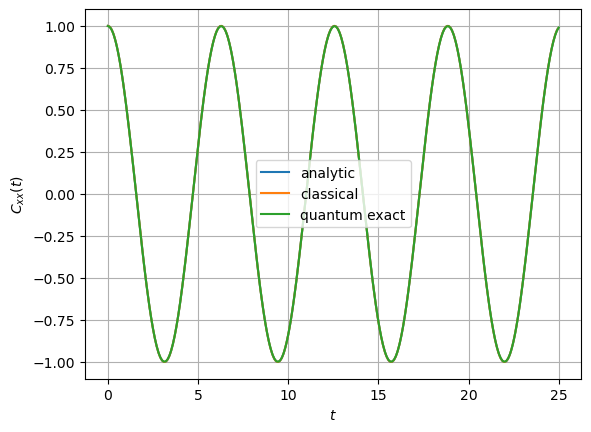

In [209]:
plt.plot(classical_harmonic[0], np.cos(classical_harmonic[0]),label='analytic')
plt.plot(classical_harmonic[0], classical_harmonic[1],label='classical')
plt.plot(exact_harmonic_HO[0], exact_harmonic_HO[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [210]:
beta = 1
if compute == 1:
    classical_slightly_anharmonic_highT = classical(-7.2,4,0.1,-5.5,5.5,0.1,'slightly_anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/slightly_anharmonic_highT.npy', classical_slightly_anharmonic_highT)

Classical Sampling: 100%|██████████| 112/112 [00:17<00:00,  6.43it/s]


In [211]:
classical_slightly_anharmonic_highT = np.load(f'{classical_path}/slightly_anharmonic_highT.npy')

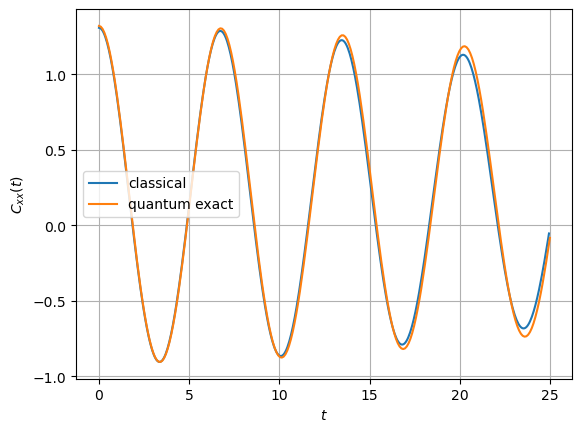

In [212]:
plt.plot(classical_slightly_anharmonic_highT[0], classical_slightly_anharmonic_highT[1],label='classical')
plt.plot(exact_slightly_anharmonic_highT_HO[0], exact_slightly_anharmonic_highT_HO[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [213]:
beta = 8
if compute == 1:
    classical_slightly_anharmonic_lowT = classical(-3,2,0.04,-5.5,5.5,0.1,'slightly_anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/slightly_anharmonic_lowT.npy', classical_slightly_anharmonic_lowT)

Classical Sampling: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


In [214]:
classical_slightly_anharmonic_lowT = np.load(f'{classical_path}/slightly_anharmonic_lowT.npy')

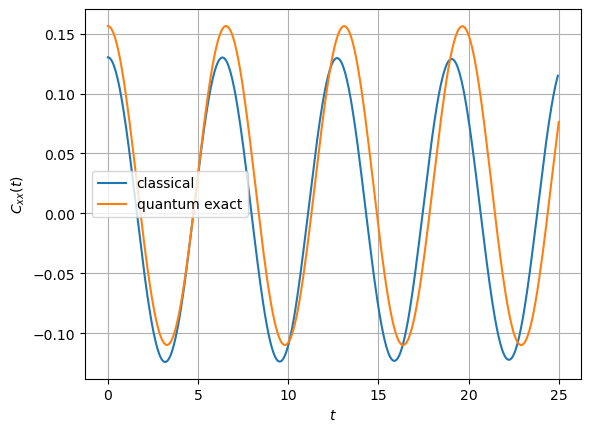

In [215]:
plt.plot(classical_slightly_anharmonic_lowT[0], classical_slightly_anharmonic_lowT[1],label='classical')
plt.plot(exact_slightly_anharmonic_lowT_HO[0], exact_slightly_anharmonic_lowT_HO[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [216]:
beta = 1
if compute == 1:
    classical_anharmonic_highT = classical(-3,3,0.05,-5.5,5.5,0.05,'anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/anharmonic_highT.npy', classical_anharmonic_highT)

Classical Sampling: 100%|██████████| 120/120 [00:21<00:00,  5.52it/s]


In [217]:
classical_anharmonic_highT = np.load(f'{classical_path}/anharmonic_highT.npy')

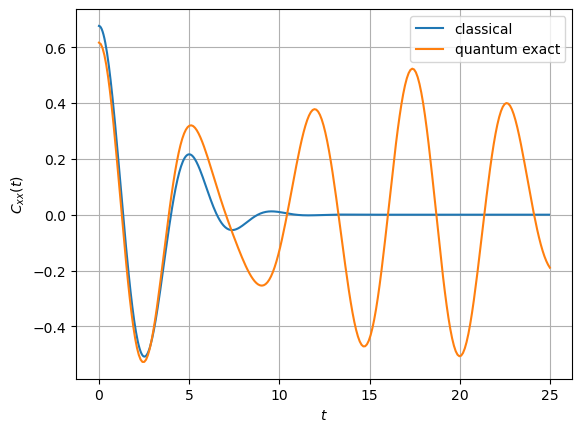

In [218]:
plt.plot(classical_anharmonic_highT[0], classical_anharmonic_highT[1],label='classical')
plt.plot(exact_anharmonic_highT_HO[0], exact_anharmonic_highT_HO[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [219]:
beta = 8
if compute == 1:
    classical_anharmonic_lowT = classical(-3,3,0.05,-5.5,5.5,0.1,'anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/anharmonic_lowT.npy', classical_anharmonic_lowT)

Classical Sampling: 100%|██████████| 120/120 [00:10<00:00, 11.27it/s]


In [220]:
classical_anharmonic_lowT = np.load(f'{classical_path}/anharmonic_lowT.npy')

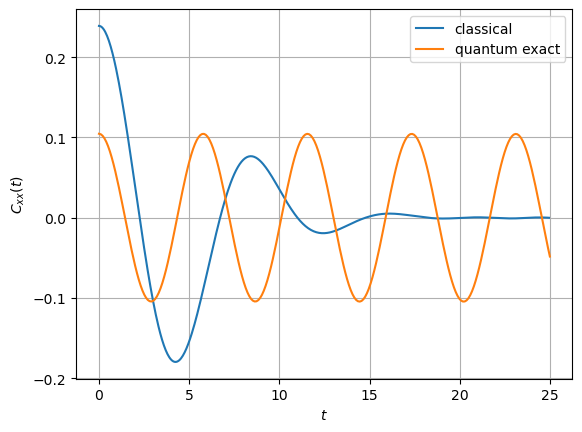

In [221]:
plt.plot(classical_anharmonic_lowT[0], classical_anharmonic_lowT[1],label='classical')
plt.plot(exact_anharmonic_lowT_HO[0], exact_anharmonic_lowT_HO[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()


# Ring Polymer

In [ ]:
# Verlet algorithm on classical polymer ring
def polymer_verlet(x_init, v_init, k_eff, potential, time, delta_t, n):
    t_values = np.arange(0, time, delta_t)
    N = len(t_values)

    # Select force function
    force_map = {
        'harmonic': F_harmonic,
        'slightly_anharmonic': F_slightly_anharmonic,
        'anharmonic': F_anharmonic
    }
    force = force_map[potential]

    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = force(x)
        x_roll_forward = np.roll(x, -1)
        x_roll_backward = np.roll(x, 1)

        spring_force = -k_eff * (2 * x - x_roll_forward - x_roll_backward)
        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = force(x_new)
        x_roll_forward_new = np.roll(x_new, -1)
        x_roll_backward_new = np.roll(x_new, 1)
        spring_force_new = -k_eff * (2 * x_new - x_roll_forward_new - x_roll_backward_new)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    x_avg = np.mean(x_verlet, axis=1)
    return x_avg

In [ ]:
# Metropolis algorithm for Boltzmann sampling (not the most efficient?)
def Metropolis(x_mean, x_std, potential, k_eff, step_size, num_step, beta_n, n):
    energy_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    energy_func = energy_map[potential]

    x = np.random.normal(x_mean, x_std, n)
    all_probs = []

    for _ in range(num_step):
        j = np.random.randint(0, n)
        x_j = x[j]
        move = step_size * (2 * np.random.rand() - 1)
        prob = np.random.rand()

        j_before = (j - 1) % n
        j_after = (j + 1) % n

        x_j_before = x[j_before]
        x_j_after = x[j_after]

        energy_old = energy_func(x_j) + 0.5 * k_eff * ((x_j - x_j_before)**2 + (x_j - x_j_after)**2)
        x_new_j = x_j + move
        energy_new = energy_func(x_new_j) + 0.5 * k_eff * ((x_new_j - x_j_before)**2 + (x_new_j - x_j_after)**2)

        delta_E = energy_new - energy_old
        prob_acc = np.exp(-beta_n * delta_E)
        acc = min(1, prob_acc)
        all_probs.append(acc)

        if prob < acc:
            x[j] = x_new_j

    mean_prob = np.mean(all_probs)
    return x, mean_prob
    



In [ ]:
def ring_polymer(x_mean, x_std, metropolis_step_size, metropolis_num_step, num_sample,potential, time, delta_t, beta, n):
    beta_n = beta / n
    k_eff = m / (beta_n**2 * hbar**2)

    C_time = np.arange(0, time, delta_t)
    N = len(C_time)
    C_func = np.zeros(N)
    mean_probs = []

    for _ in tqdm(range(num_sample)):
        x_init, mean_prob = Metropolis(x_mean, x_std, potential, k_eff,
                                       metropolis_step_size, metropolis_num_step, beta_n, n)        # Equilibriate by Metropolis to ensure Boltzmann sampling
        mean_probs.append(mean_prob)
        v_init = np.random.normal(0.0, np.sqrt(1 / (m * beta_n)), n)
        mean_x_init = np.mean(x_init)
        x_avg = polymer_verlet(x_init, v_init, k_eff, potential, time, delta_t, n)
        C_func += (x_avg * mean_x_init) / num_sample

    print("Mean acceptance probability:", np.mean(mean_probs))
    return C_time, C_func

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [225]:
beta = 1
n = 4*beta

if compute == 1:
    polymer_harmonic = ring_polymer(0,4,1.2,5000,4000,'harmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/harmonic.npy', polymer_harmonic)

100%|██████████| 4000/4000 [05:35<00:00, 11.93it/s]

Mean acceptance probability: 0.4437654880158749


In [226]:
polymer_harmonic = np.load(f'{polymer_path}/harmonic.npy')

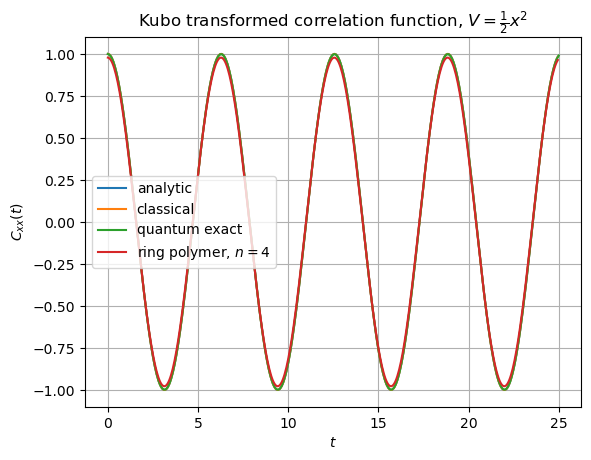

In [227]:
plt.plot(classical_harmonic[0], np.cos(classical_harmonic[0]),label='analytic')
plt.plot(classical_harmonic[0], classical_harmonic[1],label='classical')
plt.plot(exact_harmonic_HO[0], exact_harmonic_HO[1],label='quantum exact')
plt.plot(polymer_harmonic[0], polymer_harmonic[1],label=r'ring polymer, $n=4$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_harmonic.png')
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [228]:
beta = 1
n = 4*beta
if compute == 1:
    polymer_slightly_anharmonic_highT = ring_polymer(-1,4.5,1.3,10000,4000,'slightly_anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/slightly_anharmonic_highT.npy', polymer_slightly_anharmonic_highT)

100%|██████████| 4000/4000 [09:20<00:00,  7.13it/s]

Mean acceptance probability: 0.4152882134194581


In [229]:
polymer_slightly_anharmonic_highT = np.load(f'{polymer_path}/slightly_anharmonic_highT.npy')

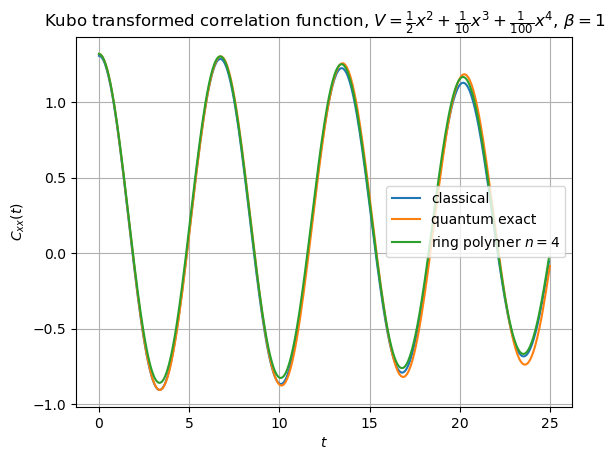

In [230]:
plt.plot(classical_slightly_anharmonic_highT[0], classical_slightly_anharmonic_highT[1],label='classical')
plt.plot(exact_slightly_anharmonic_highT_HO[0], exact_slightly_anharmonic_highT_HO[1],label='quantum exact')
plt.plot(polymer_slightly_anharmonic_highT[0], polymer_slightly_anharmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_slightly_anharmonic_highT.png')
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [231]:
beta = 8
n = 4*beta
if compute == 1:
    polymer_slightly_anharmonic_lowT = ring_polymer(0,3,1,20000,4000,'slightly_anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/slightly_anharmonic_lowT.npy', polymer_slightly_anharmonic_lowT)

100%|██████████| 4000/4000 [12:09<00:00,  5.48it/s]

Mean acceptance probability: 0.5091540788751702


In [232]:
polymer_slightly_anharmonic_lowT = np.load(f'{polymer_path}/slightly_anharmonic_lowT.npy')

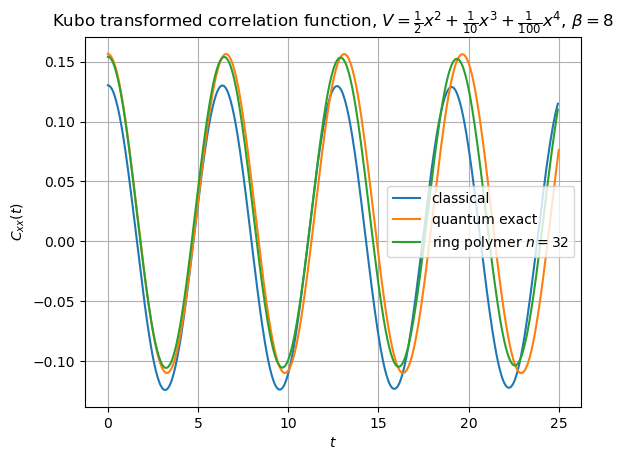

In [233]:
plt.plot(classical_slightly_anharmonic_lowT[0], classical_slightly_anharmonic_lowT[1],label='classical')
plt.plot(exact_slightly_anharmonic_lowT_HO[0], exact_slightly_anharmonic_lowT_HO[1],label='quantum exact')
plt.plot(polymer_slightly_anharmonic_lowT[0], polymer_slightly_anharmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_slightly_anharmonic_lowT.png')
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [234]:
beta = 1
n = 4*beta

if compute == 1:
    polymer_anharmonic_highT = ring_polymer(0,3,1,10000,4000,'anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/anharmonic_highT.npy', polymer_anharmonic_highT)

100%|██████████| 4000/4000 [06:47<00:00,  9.81it/s]

Mean acceptance probability: 0.5034611818998751


In [235]:
polymer_anharmonic_highT = np.load(f'{polymer_path}/anharmonic_highT.npy')

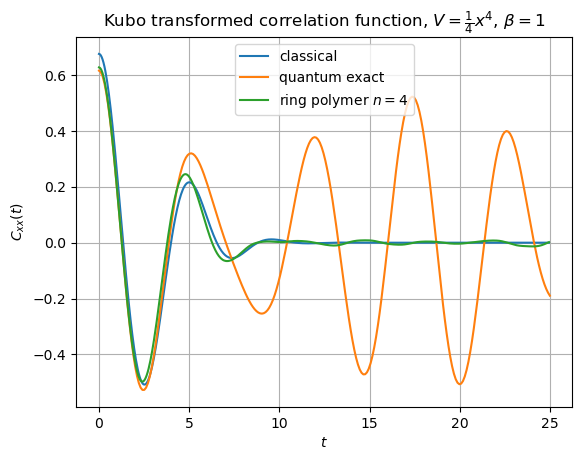

In [236]:
plt.plot(classical_anharmonic_highT[0], classical_anharmonic_highT[1],label='classical')
plt.plot(exact_anharmonic_highT_HO[0], exact_anharmonic_highT_HO[1],label='quantum exact')
plt.plot(polymer_anharmonic_highT[0], polymer_anharmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_anharmonic_highT.png')
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [237]:
beta = 8
n = 4*beta
if compute == 1:
    polymer_anharmonic_lowT = ring_polymer(0,3,0.8,10000,4000,'anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/anharmonic_lowT.npy', polymer_anharmonic_lowT)

100%|██████████| 4000/4000 [05:51<00:00, 11.39it/s]

Mean acceptance probability: 0.5826185002019565


In [238]:
polymer_anharmonic_lowT = np.load(f'{polymer_path}/anharmonic_lowT.npy')

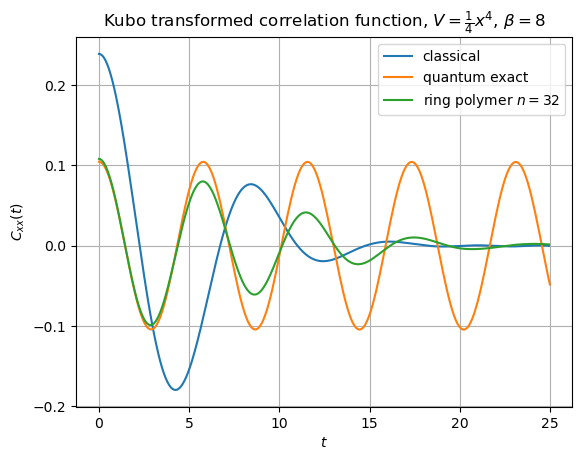

In [239]:
plt.plot(classical_anharmonic_lowT[0], classical_anharmonic_lowT[1],label='classical')
plt.plot(exact_anharmonic_lowT_HO[0], exact_anharmonic_lowT_HO[1],label='quantum exact')
plt.plot(polymer_anharmonic_lowT[0], polymer_anharmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_anharmonic_lowT.png')
plt.show()


# Cube Correlation

In [240]:
def cube_exact_quantum_x(x_min, x_max, dx, beta, potential, t_end, t_N):
    # Spatial grid
    x = np.arange(x_min, x_max, dx)
    N = len(x)

    # Vectorized potential selection
    potential_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    V = potential_map[potential](x)

    # Kinetic energy operator using finite difference
    T_diag = np.full(N, -2.0)
    T_off = np.ones(N - 1)
    T = np.diag(T_diag) + np.diag(T_off, k=1) + np.diag(T_off, k=-1)
    T *= -hbar**2 / (2 * m * dx**2)

    # Hamiltonian
    H = T + np.diag(V)

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x^3
    A = np.diag(x**3)
    A_mat = psi.T @ A @ psi  # Matrix elements <n|A|m>

    # Precompute all transition weights and matrix elements
    max_energy = 10
    valid_indices = np.where(E <= max_energy)[0]
    E = E[valid_indices]
    psi = psi[:, valid_indices]
    A_mat = A_mat[np.ix_(valid_indices, valid_indices)]
    exp_beta_E = np.exp(-beta * E)

    # Build outer products for efficient broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z

    return times, C_t

In [248]:
def cube_exact_quantum_HO(n_max, beta, potential, t_end, t_N):

    potential_coefficients = {
        'harmonic': [1/2,0,0],
        'slightly_anharmonic': [1/2,1/10,1/100],
        'anharmonic': [0,0,1/4]
    }

    dim = n_max + 4

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    adag = a.T

    # Position operator
    x = np.sqrt(hbar/(2*m)) * (a + adag)

    x2 = x @ x
    x3 = x2 @ x
    x4 = x3 @ x

    x_powers = [x2,x3,x4]

    V = np.zeros((dim,dim))
    for i in range(0,3):
        V += potential_coefficients[potential][i] * x_powers[i]

    # Kinetic energy operator

    dv = np.sqrt(m * hbar / 2) * (adag - a)

    T = -(dv @ dv) / (2 * m)

    # Hamiltonian
    H = T + V

    H = H[:n_max,:n_max]

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x
    A = x3[:n_max,:n_max]
    A_mat = psi.T @ A @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z

    return times, C_t

In [249]:
def cube_classical(x_low, x_up, x_step, v_low, v_up, v_step, potential, time, delta_t, beta):
    C_time = np.arange(0, time, delta_t)
    N = len(C_time)

    energy_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    energy = energy_map[potential]

    C_func = np.zeros(N)
    partition_function = 0.0

    x_vals = np.arange(x_low, x_up, x_step)
    v_vals = np.arange(v_low, v_up, v_step)

    for x_init in tqdm(x_vals, desc="Classical Sampling"):
        for v_init in v_vals:
            E = energy(x_init) + 0.5 * m * v_init**2
            weight = np.exp(-beta * E)
            x_traj, _ = verlet(x_init, v_init, potential, time, delta_t)

            C_func += x_traj**3 * x_init**3 * weight
            partition_function += weight

    C_func /= partition_function
    return C_time, C_func

In [250]:
def polymer_verlet_cube(x_init, v_init, k_eff, potential, time, delta_t, n):
    t_values = np.arange(0, time, delta_t)
    N = len(t_values)

    # Select force function
    force_map = {
        'harmonic': F_harmonic,
        'slightly_anharmonic': F_slightly_anharmonic,
        'anharmonic': F_anharmonic
    }
    force = force_map[potential]

    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = force(x)
        x_roll_forward = np.roll(x, -1)
        x_roll_backward = np.roll(x, 1)

        spring_force = -k_eff * (2 * x - x_roll_forward - x_roll_backward)
        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = force(x_new)
        x_roll_forward_new = np.roll(x_new, -1)
        x_roll_backward_new = np.roll(x_new, 1)
        spring_force_new = -k_eff * (2 * x_new - x_roll_forward_new - x_roll_backward_new)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    x_cube_avg = np.mean(x_verlet**3, axis=1)
    return x_cube_avg

In [251]:
def cube_ring_polymer(x_mean, x_std, metropolis_step_size, metropolis_num_step, num_sample,potential, time, delta_t, beta, n):
    beta_n = beta / n
    k_eff = m / (beta_n**2 * hbar**2)

    C_time = np.arange(0, time, delta_t)
    N = len(C_time)
    C_func = np.zeros(N)
    mean_probs = []

    for _ in tqdm(range(num_sample)):
        x_init, mean_prob = Metropolis(x_mean, x_std, potential, k_eff,
                                       metropolis_step_size, metropolis_num_step, beta_n, n)
        mean_probs.append(mean_prob)
        v_init = np.random.normal(0.0, np.sqrt(1 / (m * beta_n)), n)
        mean_x_cube_init = np.mean(x_init**3)
        x_cube_avg = polymer_verlet_cube(x_init, v_init, k_eff, potential, time, delta_t, n)
        C_func += (x_cube_avg * mean_x_cube_init) / num_sample

    print("Mean acceptance probability:", np.mean(mean_probs))
    return C_time, C_func

## $\beta=1$

In [256]:
beta = 1
n = 4*beta

if compute == 1:
    cube_exact_harmonic_highT_x = cube_exact_quantum_x(-5.5,5.5,0.05,beta,'harmonic',25,250)
    cube_exact_harmonic_highT_HO = cube_exact_quantum_HO(20,beta,'harmonic',25,250)
    cube_classical_harmonic_highT = cube_classical(-5.5,5.5,0.1,-5.5,5.5,0.1,'harmonic',25,0.05,beta)
    cube_ring_polymer_harmonic_highT = cube_ring_polymer(0,5.5,1.5,10000,5000,'harmonic',25,0.05,beta,n)
    np.save(f'{cube_path}/exact_harmonic_highT_x.npy', cube_exact_harmonic_highT_x)
    np.save(f'{cube_path}/exact_harmonic_highT_HO.npy', cube_exact_harmonic_highT_HO)
    np.save(f'{cube_path}/classical_harmonic_highT.npy', cube_classical_harmonic_highT)
    np.save(f'{cube_path}/ring_polymer_harmonic_highT.npy', cube_ring_polymer_harmonic_highT)

Classical Sampling:   0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [07:10<00:00, 11.60it/s]

Mean acceptance probability: 0.3660971538099828


In [257]:
cube_exact_harmonic_highT_x = np.load(f'{cube_path}/exact_harmonic_highT_x.npy')
cube_exact_harmonic_highT_HO = np.load(f'{cube_path}/exact_harmonic_highT_HO.npy')
cube_classical_harmonic_highT = np.load(f'{cube_path}/classical_harmonic_highT.npy')
cube_ring_polymer_harmonic_highT = np.load(f'{cube_path}/ring_polymer_harmonic_highT.npy')

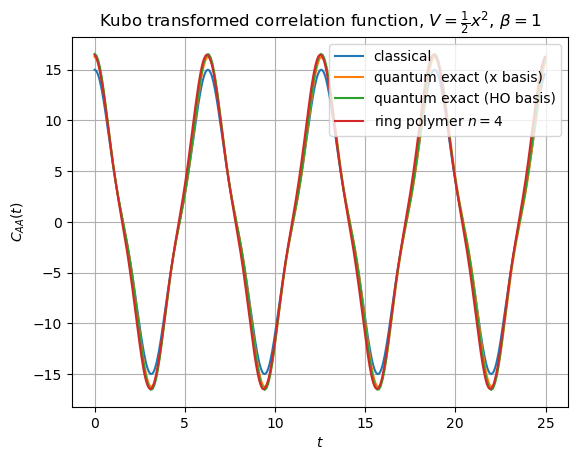

In [258]:
plt.plot(cube_classical_harmonic_highT[0],cube_classical_harmonic_highT[1],label='classical')
plt.plot(cube_exact_harmonic_highT_x[0],cube_exact_harmonic_highT_x[1],label='quantum exact (x basis)')
plt.plot(cube_exact_harmonic_highT_HO[0],cube_exact_harmonic_highT_HO[1],label='quantum exact (HO basis)')
plt.plot(cube_ring_polymer_harmonic_highT[0],cube_ring_polymer_harmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{AA}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('CAA_harmonic_highT.png')
plt.show()


## $\beta=8$

In [259]:
beta = 8
n = 4*beta
if compute == 1:
    cube_exact_harmonic_lowT_x = cube_exact_quantum_x(-5,5,0.05,beta,'harmonic',25,250)
    cube_exact_harmonic_lowT_HO = cube_exact_quantum_HO(10,beta,'harmonic',25,250)
    cube_classical_harmonic_lowT = cube_classical(-5,5,0.05,-4,4,0.1,'harmonic',25,0.05,beta)
    cube_ring_polymer_harmonic_lowT = cube_ring_polymer(0,4.5,1.2,10000,4000,'harmonic',25,0.05,beta,n)
    np.save(f'{cube_path}/exact_harmonic_lowT_x.npy', cube_exact_harmonic_lowT_x)
    np.save(f'{cube_path}/exact_harmonic_lowT_HO.npy', cube_exact_harmonic_lowT_HO)
    np.save(f'{cube_path}/classical_harmonic_lowT.npy', cube_classical_harmonic_lowT)
    np.save(f'{cube_path}/ring_polymer_harmonic_lowT.npy', cube_ring_polymer_harmonic_lowT)

Classical Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [05:46<00:00, 11.54it/s]

Mean acceptance probability: 0.4472100081823456


In [260]:
cube_exact_harmonic_lowT_x = np.load(f'{cube_path}/exact_harmonic_lowT_x.npy')
cube_exact_harmonic_lowT_HO = np.load(f'{cube_path}/exact_harmonic_lowT_HO.npy')
cube_classical_harmonic_lowT = np.load(f'{cube_path}/classical_harmonic_lowT.npy')
cube_ring_polymer_harmonic_lowT = np.load(f'{cube_path}/ring_polymer_harmonic_lowT.npy')

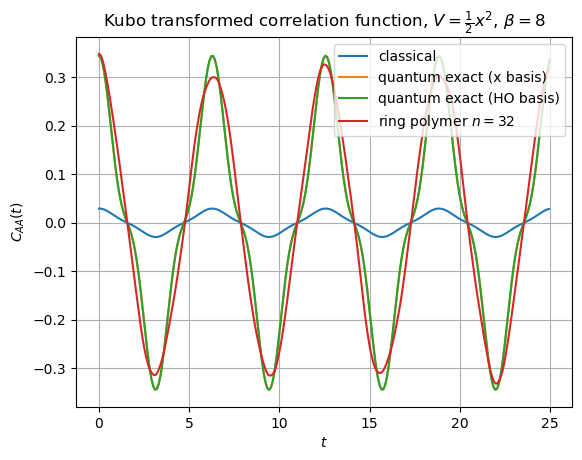

In [261]:
plt.plot(cube_classical_harmonic_lowT[0],cube_classical_harmonic_lowT[1],label='classical')
plt.plot(cube_exact_harmonic_lowT_x[0],cube_exact_harmonic_lowT_x[1],label='quantum exact (x basis)')
plt.plot(cube_exact_harmonic_lowT_HO[0],cube_exact_harmonic_lowT_HO[1],label='quantum exact (HO basis)')
plt.plot(cube_ring_polymer_harmonic_lowT[0],cube_ring_polymer_harmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{AA}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('CAA_harmonic_lowT.png')
plt.show()
